# Introduction

Outlier detection in time-series data can be a lot more complicated than ordinary multivariate data, owing to the underlying assumption of independent observations of most unsupervised machine-learning algorithms, being violated. In this notebook, we have attempted to adapt an algorithm proposed by __[Yufeng et. al.](http://dx.doi.org/10.1155/2014/879736)__ to detect outliers in a __hydrological time-series using sliding window prediction__ technique.

# Window

A window of observations in the context of a specific time-series data point could be considered as a set of its closest 2k obervations either to the left of it, or k observations to the left and k to the right. 

# The proposed Algorithm

The algorithm essentially uses a window of 2k observations for each data point and uses this window to predict a confidence interval and an estimate for the data point itself. Once these two have been calculated, it is verified whether the data point falls within the interval or not. If it does not fall within this interval, we classify it as an outlier and replace it with the estimated value. We then move on to the next data-point and repeat the same procedure.

# Underlying assumption

The underlying assumption is that the time-series follows a multivariate Gaussian distribution (Normal distribution), each variable having a marginal density function represented by the formulae:

$\large f(x_t) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{x_t-\mu}{2 \sigma^2}}$, where $\large \mu$ and $\large \sigma$ are unknown parameters of the distribution.

# Necessary packages and modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t, norm
import time
import json
import requests
from bokeh.io import output_notebook, show
from bokeh.plotting import gridplot, figure
from math import pi
import datetime as dt

# Data Ingestion

(i) Use the appropriate url/address.

(ii). Drop Unnecessary features.

In [ ]:
cwc_dict = {
    "cwc-1":"e5b38c40-a384-11e8-9be5-5143651d0421",
    "cwc-2":"ecafb9b0-a384-11e8-9be5-5143651d0421",
    "cwc-3":"f1bbd6f0-a384-11e8-9be5-5143651d0421",
    "cwc-4":"f6fdd140-a384-11e8-9be5-5143651d0421",
    "cwc-5":"fbcff2c0-a384-11e8-9be5-5143651d0421",
    "cwc-6":"01b7f110-a385-11e8-9be5-5143651d0421",
    "cwc-7":"0793e170-a385-11e8-9be5-5143651d0421",
    "cwc-8":"0d3a69f0-a385-11e8-9be5-5143651d0421",
    "cwc-9":"127e11f0-a385-11e8-9be5-5143651d0421",
    "cwc-10":"17f54d10-a385-11e8-9be5-5143651d0421",
    "cwc-11":"23543860-a385-11e8-9be5-5143651d0421",
    "cwc-12":"28642630-a385-11e8-9be5-5143651d0421",
    "cwc-13":"2e07a170-a385-11e8-9be5-5143651d0421",
    "cwc-14":"329985a0-a385-11e8-9be5-5143651d0421",
    "cwc-15":"388a0f70-a385-11e8-9be5-5143651d0421",
    "cwc-16":"3d954250-a385-11e8-9be5-5143651d0421",
    "cwc-17":"43944b10-a385-11e8-9be5-5143651d0421",
    "cwc-18":"4e0aab20-a385-11e8-9be5-5143651d0421",
    "cwc-19":"14d8a310-ce1f-11e8-9be5-5143651d0421"
    }

def getData(device_name,start_date,end_date,
            server_url="http://cwc.kritsnam.in:8080",
            username="tenant@kritsnam.in",password="tenant"):
    '''
    Inputs:
      `device_name` : (string) e.g. "cwc-1", "cwc-12" and so on
      `start_date` : (string) in format '%Y-%m-%d'
      `end_date` : (string) in format '%Y-%m-%d'
    '''
    prev = time.strptime(start_date, '%Y-%m-%d')
    prev = int(time.mktime(prev))
    prev = str(prev)
    start_date = prev + str("000")
    print(start_date)

    current = time.strptime(end_date, '%Y-%m-%d')
    current = int(time.mktime(current))
    current_1 = current + 86400
    current_1 = str(current_1)
    end_date = current_1 + str("000")
    print(end_date)

    data = '{{"username":"{}","password":"{}"}}'.format(username,password)
    print(data)
    headers_one = {'Accept': 'application/json',
                   'Content-Type':'application/json'}
    r = requests.post(url=server_url+'/api/auth/login',
                      data=data, headers = headers_one)
    JWT_TOKEN = r.json()
    JWT_TOKEN = JWT_TOKEN['token']
    print(JWT_TOKEN)

    headers_two = {
        'Content-Type': 'application/json',
        'X-Authorization': 'Bearer {}'.format(JWT_TOKEN),
    }
    params = {
        'keys': 'max,mean,median,mode',
        'startTs': start_date,
        'endTs': end_date,
        'interval': 300000,
        'limit':100000,
        'agg': 'NONE'
    }
    response = requests.get(server_url+'/api/plugins/telemetry/DEVICE/{}/values/timeseries'.format(cwc_dict[device_name]),
                            headers=headers_two, params=params).json()

    keys = list(response.keys())
    values = list(response.values())

    valuesDF = pd.DataFrame(columns=keys)
    for index,items in enumerate(values[0]):
        singleData = {}
        ts = time.strftime("%d/%m/%Y %H:%M:%S",
                           time.localtime(int(items['ts'])/1000.0))
        for i,j in enumerate(keys):
            c = values[i][index]['value']
            singleData[j] = c
        df = pd.DataFrame(singleData, index=[pd.to_datetime(ts, dayfirst=True)])
        valuesDF = valuesDF.append(df, sort=False)
    valuesDF = ((valuesDF.sort_index()).astype(np.float64)).reset_index()
    #valuesDF= (valuesDF.astype(np.float64)).reset_index()
    return valuesDF

In [ ]:
df = getData("cwc-10", "2019-01-01", "2019-03-01")
##df = df.reset_index()


In [2]:
df = pd.read_csv("CWC-5Removed.csv")
#df.drop(columns = ['Flagged'], inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_index(ascending = False).reset_index(drop = True)
df

Timestamp   max     mean  median  mode
0     2018-10-05 00:10:24  2831  2820.93    2821  2821
1     2018-10-05 00:20:31  2828  2820.87    2820  2817
2     2018-10-05 00:30:38  2826  2818.23    2820  2815
3     2018-10-05 00:40:45  2832  2822.30    2823  2821
4     2018-10-05 00:50:52  2832  2821.00    2822  2822
...                   ...   ...      ...     ...   ...
35438 2019-08-02 16:24:58  4404  4398.57    4399  4400
35439 2019-08-02 16:36:17  4402  4397.57    4399  4399
35440 2019-08-02 16:46:29  4405  4399.93    4400  4402
35441 2019-08-02 16:58:16  4405  4400.33    4400  4400
35442 2019-08-02 17:08:28  4407  4401.77    4401  4401

[35443 rows x 5 columns]

# Exploratory/Preliminary Visualization

In [18]:
output_notebook()

fig_ax = figure(plot_width = 900, plot_height = 500, x_axis_type = 'datetime')
fig_ax.grid.visible = False
ax_fig = fig_ax.circle(df.index.values, df.iloc[:, 1].values, alpha = 0.5)
fig_ax.xaxis[0].formatter.days = "%Y-%m-%d %H:%M:%S"
fig_ax.xaxis.major_label_orientation = pi/4
fig_ax.xaxis.major_label_text_font_size = "10pt"
show(fig_ax)

Loading BokehJS ...

# The Algorithm 

# (i). For Historical data

First let us define,

$\large d_t$ : $t^{th}$  *observation  in  the  time-series.*

$\large \eta^{ \left( k \right) } _ t = \{ d_{t-k}, d_{t-k+1}, ..., d_{t-1}, d_{t+1}, ..., d_{t+k-1}, d_{t+k} \}$

$\large w_{t-k} \left( \propto \frac{1}{d_t} \right) $ : *Weight associated with* $d_{t-k}$ *based on it's distance from d_t*.

Then calculate,

$\large\hat{d_t} = \frac{\sum_{i = t-k}^{t-1} w_i d_i + \sum_{i = t+1}^{t+k} w_i d_i}{\sum_{i = t-k}^{t-1} w_i + \sum_{i = t+1}^{t+k} w_i }$

$\large d_{t}^{\left( Conf. Int \right)} =\hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}}$ , where $t_\alpha$ is that point of a t distribution with 2k-1 degrees of freedom, such that  $\alpha$ proportion of points of the distribution lie to the right of it and $1-\alpha$ proportion of points lie to the left of it. $\large \hat{s}$ is the standard deviation of $\large \eta^{k} _t$
 

 If $\large\hat{d_t} \notin  \left[ \hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}} \right]$ then $d_t$ is deemed an outlier and is replaced by $\hat{d_t}$
 
Repeat the process for $\large d_{t+1}, d_{t+2} ...$

$k$ and $\alpha$ are parameters of the model.

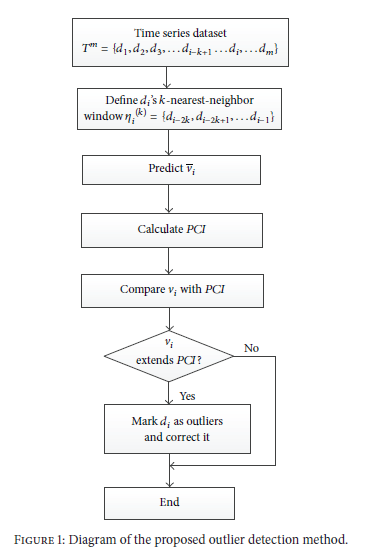

In [5]:
T = df.iloc[:, 4]#.copy()
time_index = df.iloc[:, 0]#.copy()
#Function to calulate the estimate and the PCI for each observation in the time-series
def feature_extract(i, T, k, alpha, time_index):
    k_delta = dt.timedelta(hours = k)
    d_original = T[i]
    start_time = time_index[i] - k_delta
    end_time = time_index[i] + k_delta
    win_left_index = np.where((time_index >  start_time) & (time_index < time_index[i]))
    win_right_index = np.where((time_index > time_index[i]) & (time_index < end_time))
    win_index = np.hstack((win_left_index, win_right_index))
    window = T[win_index[0]]
    wt = norm.pdf(window, loc = d_original, scale = k)
    d_estimate = ((window*wt).sum()/wt.sum())
    pci_l = d_estimate - t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(window)
    pci_r = d_estimate + t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(window)
    state = 0
    if (d_original < pci_l) or (d_original > pci_r):
        state = 1
    dat = [d_estimate, pci_l, pci_r, state]
    return dat

In [7]:
feature_extract(0, T, 1, 0.95, time_index)

[2817.693985344857, 2799.4677546615235, 2835.9202160281907, 0]

In [13]:
# Function to compute outliers for an entire data-set
def fin_calc(k, alpha):
    T = df.iloc[:, 4].copy()
    fin = []
    for i in range(0, len(T)):
        res = feature_extract(i, T, k, alpha, time_index)
        fin.append(res)
        #if res[3] == 1:
        #    T[i] = res[0]
    df2 = pd.DataFrame(fin, index = range(0, len(T)), columns = ['Estimated', 'Lower', 'Upper', 'Status'])
    return df2

In [14]:
k = 2
alpha = 0.95
df2 = fin_calc(k, alpha)
df2

C:\Users\Sourav\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Sourav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
C:\Users\Sourav\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


Estimated        Lower        Upper  Status
0      2820.425205  2813.115081  2827.735329       0
1      2817.144110  2808.542454  2825.745766       0
2      2815.840483  2807.320622  2824.360345       0
3      2820.938928  2811.996526  2829.881330       0
4      2821.365972  2812.801396  2829.930548       0
...            ...          ...          ...     ...
35438  4400.685717  4384.728634  4416.642799       0
35439  4400.500903  4384.433716  4416.568090       0
35440  4400.965703  4383.818374  4418.113033       0
35441  4400.526919  4383.684496  4417.369343       0
35442  4400.583122  4382.730103  4418.436141       0

[35443 rows x 4 columns]

In [10]:
len(df2[df2['Status'] == 1])

52

In [15]:
df2 = pd.merge(df, df2, 'right', left_index = True, right_index = True)

In [16]:
df2.head()

Timestamp   max     mean  median  mode    Estimated        Lower  \
0 2018-10-05 00:10:24  2831  2820.93    2821  2821  2820.425205  2813.115081   
1 2018-10-05 00:20:31  2828  2820.87    2820  2817  2817.144110  2808.542454   
2 2018-10-05 00:30:38  2826  2818.23    2820  2815  2815.840483  2807.320622   
3 2018-10-05 00:40:45  2832  2822.30    2823  2821  2820.938928  2811.996526   
4 2018-10-05 00:50:52  2832  2821.00    2822  2822  2821.365972  2812.801396   

         Upper  Status  
0  2827.735329       0  
1  2825.745766       0  
2  2824.360345       0  
3  2829.881330       0  
4  2829.930548       0

In [19]:
fig= figure(plot_width = 900, plot_height = 500, x_axis_type = 'datetime', title = 'Figure depicting Confidence-Band, original and estimated values of max water level(in mm)')
fig.grid.visible = False
fig.line(df2.iloc[:, 0].values, df2.iloc[:, 6].values, line_dash = 'solid', line_color = 'blue', legend = "Lower Confidence Limit")
fig.line(df2.iloc[:, 0].values, df2.iloc[:, 7].values, line_dash = 'solid', line_color = 'blue', legend = "Upper Confidence Limit")
fig.line(df2.iloc[:, 0].values, df2.iloc[:, 4].values, line_dash = 'solid', line_color = 'magenta', legend = "Original Values")
fig.circle(df2.iloc[:, 0].values, df2.iloc[:, 4].values, color = 'magenta', alpha = 0.5, size = 2.5, legend = "Original Values")
fig.line(df2.iloc[:, 0].values, df2.iloc[:, 5].values, line_dash = 'solid', line_color = 'black', legend = "Predicted Values")
fig.x(df2.iloc[:, 0].values, df2.iloc[:, 5].values, size = 2.0, line_color = 'black', legend = "Predicted Values")
fig.xaxis[0].formatter.days = "%Y-%m-%D %H:%M:%S"
fig.xaxis.major_label_orientation = pi/4
fig.xaxis.axis_label = "Date"
fig.yaxis.axis_label = "Max.depth"
#fig.legend.label_text_font_size = "5pt"
show(fig)
#ax.set_title('First 200 observations', size = 20)
#ax.legend(loc = "upper left", fontsize = 20)

In [20]:
fig2 = figure(plot_width = 900, plot_height = 500, x_axis_type = 'datetime', title = 'Outliers vs Non-outliers amongst water-levels(Confidence = 0.90, k=6)')
fig2.grid.visible = False
fig2.x(df2[df2.iloc[:, -1]==1].iloc[:, 0], df2[df2.iloc[:, -1]==1].iloc[:, 4], alpha = 1, color = 'red')
fig2.circle(df2[df2.iloc[:, -1]==0].iloc[:, 0], df2[df2.iloc[:, -1]==0].iloc[:, 4], alpha = 0.3)
fig2.xaxis[0].formatter.days = "%Y-%m-%D %H:%M:%S"
fig2.xaxis.major_label_orientation = pi/4
fig2.xaxis.axis_label = "Date"
fig2.yaxis.axis_label = "Max. depth"
fig2.title.text_font_size = "15pt"
show(fig2)
#ax.legend(loc = 1, fontsize = 20)
#ax.set_title('Outliers vs Non-outliers amongst water-levels (confidence = 0.97, k = 6)', size = 20)
#ax.set_ylabel('Water level(in mm)', size = 20)
#ax.set_xlabel('$x_t$', size = 20)

# (ii). For new observations.

Let us first define,

$\large d_t$ : $t^{th}$  *observation  in  the  time-series.*

$\large \eta^{ \left( k \right)}_t = \{t_{t-2k}, t_{t-2k+1}, ..., t_{t-1} \}$

$\large w_{t-k} \left( \propto \frac{1}{d_t} \right) $ : *Weight associated with* $d_{t-k}$ *based on it's distance from d_t*.

Then we calulate,

$\large\hat{d_t} = \frac{\sum_{i = t-2k}^{t-1} w_i d_i}{\sum_{i = t-2k}^{t-1} w_i}$

$\large d_{t}^{\left( Conf. Int \right)} =\hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}}$ , where $t_\alpha$ is that point of a t distribution with 2k-1 degrees of freedom, such that  $\alpha$ proportion of points of the distribution lie to the right of it and $1-\alpha$ proportion of points lie to the left of it. $\large \hat{s}$ is the standard deviation of $\large \eta^{k} _t$

If $\large\hat{d_t} \notin  \left[ \hat{d_t} \pm t_{{\frac{\alpha}{2}},{2k-1}} \hat{s} \sqrt{1 + \frac{1}{2k}} \right]$ then $d_t$ is deemed an outlier and is replaced by $\hat{d_t}$

Repeat the process for  $\large 𝑑_{𝑡+1}, 𝑑_{𝑡+2}... $
𝑘  and  𝛼  are parameters of the model.

In [ ]:
def new_obs_pred(d_obs, T, k, alpha):
    d_original = d_obs[1]
    window_left = df.iloc[:, 1].values[len(df)-2*k:len(df)]
    wt_left = np.arange(1, 2*k+1)
    d_estimate = sum(window_left*wt_left)/sum(wt_left)
    pci_l = d_estimate - t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(window_left)
    pci_r = d_estimate + t.ppf(alpha, df = 2*k-1)*(np.sqrt(1+1/(2*k)))*np.std(window_left)
    state = 0.0
    if (d_original<pci_l) or (d_original>pci_r):
        state = 1.0    
    dat = [d_obs[0], d_original, d_obs[2], d_obs[3], d_obs[4], d_estimate, pci_l, pci_r, state]
    return dat

In [ ]:
d_obs = df.iloc[len(df)-k]
ob = new_obs_pred(d_obs, T, 6, 0.97)

In [ ]:
ob

In [ ]:
df2.columns

In [ ]:
df2 = df2.append(pd.Series(ob, index = df2.columns), ignore_index = True)
df2.tail(5)

# Applying the algorithm on multiple devices.

In [ ]:
a = list(getData("cwc-{}".format(i+1), "2019-01-01", "2019-02-01") for i in range(0, 10))

"""for i in a:
    print(i.head())"""

In [ ]:
k = 3
alpha = 0.90
def apply_over_list(elem):
    T = elem.iloc[:, 1].values
    T2 = T.copy()
    d_1 = fin_calc(T, k, alpha)
    d_1 = pd.merge(elem, d_1, left_index = True, right_index = True)
    return d_1
a = list(apply_over_list(elem) for elem in a)   

In [ ]:
for i in a:
    print(i.head())

# Visualization of the confidence intervals along with the original and predicted observations.

In [ ]:
g = [[], [], [], [], []]
c = 0
for i in g:
    for j in range(2):
        fig= figure(x_axis_type = 'datetime', title = 'CW-{}'.format(c+1))
        fig.grid.visible = False
        fig.line(a[c].iloc[:, 0].values, a[c].iloc[:, 6].values, line_dash = 'solid', line_color = 'blue', legend = "Upper Confidence Limit")
        fig.line(a[c].iloc[:, 0].values, a[c].iloc[:, 7].values, line_dash = 'solid', line_color = 'blue', legend = "Lower Confidence Limit")
        fig.line(a[c].iloc[:, 0].values, a[c].iloc[:, 1].values, line_dash = 'solid', line_color = 'magenta', legend = "Original Values")
        fig.circle(a[c].iloc[:, 0].values, a[c].iloc[:, 1].values, color = 'magenta', alpha = 0.5, size = 2.5, legend = "Original Values")
        fig.line(a[c].iloc[:, 0].values, a[c].iloc[:, 5].values, line_dash = 'solid', line_color = 'black', legend = "Predicted Values")
        fig.x(a[c].iloc[:, 0].values, a[c].iloc[:, 5].values, size = 2.0, line_color = 'black', legend = "Predicted Values")
        fig.xaxis[0].formatter.days = "%Y-%m-%D %H:%M:%S"
        fig.title.align = "center"
        fig.xaxis.major_label_orientation = pi/4
        fig.xaxis.major_label_text_font_size = "5pt"
        fig.xaxis.axis_label = "Date"
        fig.xaxis.axis_label_text_font_size = "5pt"
        fig.yaxis.axis_label = "Max.depth(in mm)"
        fig.yaxis.axis_label_text_font_size = "5pt"
        fig.yaxis.minor_tick_line_color = None
        #fig.yaxis.major_tick_line_
        fig.yaxis.major_label_text_font_size = "5pt"
        fig.legend.label_text_font_size = "5pt"
        fig.legend.glyph_width = 10
        fig.legend.label_height = 6
        fig.legend.background_fill_alpha = 0.5
        fig.legend.padding = 1
        fig.legend.spacing = 1
        c+=1
        i.append(fig)

fig3 = gridplot(g, plot_width = 500, plot_height = 300)
show(fig3)

# Visualization of the data points with outliers marked in red.

In [ ]:
ax1 = [[], [], [], [], []]
c = 0
for i in ax1:
    for j in range(2):
        p = figure(x_axis_type = 'datetime', title = 'CW-{}'.format(c+1))
        p.grid.visible = False
        p.xaxis[0].formatter.days = "%Y-%m-%D %H:%M:%S"
        p.xaxis.major_label_text_font_size = "5pt"
        p.xaxis.major_label_orientation = pi/4
        p.yaxis.minor_tick_line_color = None
        p.yaxis.major_label_text_font_size = "5pt"
        p.title.align = 'center'
        #p.title.text_font_size = "5pt"
        p.x(a[c][a[c].iloc[:, -1]==1].iloc[:, 0], a[c][a[c].iloc[:, -1]==1].iloc[:, 1], alpha = 1, color = 'red', legend = 'Outliers')
        p.circle(a[c][a[c].iloc[:, -1]==0].iloc[:, 0], a[c][a[c].iloc[:, -1]==0].iloc[:, 1], alpha = 0.5, legend = 'Non-outliers')
        p.legend.background_fill_alpha = 0.5
        c+=1
        i.append(p)
fig4 = gridplot(ax1, plot_width = 500, plot_height = 300)
show(fig4)